# Predicting Major League Baseball Season Win-Loss Records
## Big Data Analytics, Final Project
### *By: Jon Anderson*


---



In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import uniform
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
pd.options.mode.chained_assignment = None  # default='warn'
import warnings; warnings.simplefilter('ignore')

Data Import and Cleansing

Notes:

* Data was collected by web scraping with the BeautifulSoup package, scripts are available upon demand (sites: baseball-reference.com, thebaseballcube.com
* We normalized payroll and attendance by transforming each value to a percentage relative to the year average for that year. We realized this was necessary after seeing how much different overall payroll at the two ends of our data (it has gone up considerably, as you will see).
* Since we are predicting ***next year's*** win totals, we needed to add a new column that shifts the wins column down one slot so we have the predictors and the prediction values on the same row, because of this, we had to make the 'NextYearW' column for the 2019 rows blank, since we do not have data for 2020 yet - that's what we're trying to predict










In [3]:
#mlb = pd.read_csv('drive/My Drive/Colab Notebooks/data/MLBData.csv')
mlb = pd.read_csv('g:\\gradschool\\bigdata\\project\\data\\MLBData.csv')
mlb = mlb.loc[:, ~mlb.columns.str.contains('^Unnamed')]
mlb['Year'] = pd.to_datetime(mlb['Year'], format='%Y')

payroll = mlb[['Year','Payroll']]
payroll = payroll.groupby(['Year'], as_index=False).mean()
payroll = payroll.sort_values(by='Year', ascending=True)
avgpayrolldict = dict(zip(payroll.Year, payroll.Payroll))

attendance = mlb[['Year','Attend']]
attendance = attendance.groupby(['Year'], as_index=False).mean()
attendance = attendance.sort_values(by='Year',ascending=True)
avgattendancedict = dict(zip(attendance.Year, attendance.Attend))

mlb = mlb.sort_values(by='Year')
mlb['YearAvgPay'] = mlb['Year'].map(avgpayrolldict)
mlb['PayrollDiff'] = round(mlb['Payroll'] / mlb['YearAvgPay'],3)

mlb['YearAvgAttend'] = mlb['Year'].map(avgattendancedict)
mlb['AttendDiff'] = round(mlb['Attend'] / mlb['YearAvgAttend'],3)

mlb = mlb.sort_values(by=['Team','Year'])
mlb['NextYearW'] = mlb['W'].shift(-1)
mlb.loc[mlb.Year=='2019-01-01', 'NextYearW'] = ''

viewit = mlb.sample(frac=1)
viewit.head(10)

,Team,Year,W,L,Pct,Attend,Payroll,OPS,ERA,YearAvgPay,PayrollDiff,YearAvgAttend,AttendDiff,NextYearW
472,Cincinnati Reds,2004-01-01,76,86,0.469136,2287250,46615250,0.749,5.19,6.904220e+07,0.675,2.434099e+06,0.940,73
556,New York Mets,2001-01-01,82,80,0.506173,2658330,93674428,0.710,4.07,6.542806e+07,1.432,2.419370e+06,1.099,75
214,Boston Red Sox,2012-01-01,69,93,0.425926,3043003,173186617,0.730,4.70,9.802191e+07,1.767,2.495309e+06,1.219,97
571,Boston Red Sox,2000-01-01,85,77,0.524691,2585895,81210333,0.764,4.23,5.620906e+07,1.445,2.378630e+06,1.087,82
458,Detroit Tigers,2004-01-01,72,90,0.444444,1917004,46832000,0.786,4.93,6.904220e+07,0.678,2.434099e+06,0.788,71
88,San Diego Padres,2017-01-01,71,91,0.438272,2138491,34574400,0.692,4.67,1.292761e+08,0.267,2.422627e+06,0.883,66
326,Colorado Rockies,2009-01-01,92,70,0.567901,2665080,75201000,0.784,4.22,8.851317e+07,0.850,2.447686e+06,1.089,83
297,Colorado Rockies,2010-01-01,83,79,0.512346,2875245,84227000,0.760,4.14,9.102006e+07,0.925,2.435392e+06,1.181,73
501,St. Louis Cardinals,2003-01-01,85,77,0.524691,2910386,83486666,0.804,4.60,7.092878e+07,1.177,2.254335e+06,1.291,105
82,St. Louis Cardinals,2017-01-01,83,79,0.512346,3448337,146630000,0.760,4.01,1.292761e+08,1.134,2.422627e+06,1.423,88


Our DataFrame is ready, so let's derive some insights from our data so we can leran a little bit about the last 20 years in Major League Baseball.

In [0]:
# Attendance DataFrame for Graphing
attend = mlb[['Year','Attend']]
attend['Year'] = pd.to_datetime(attend['Year'], format='%Y')
attend = attend.groupby(['Year'], as_index=True).sum()
attend = attend.sort_values(by='Year', ascending=True)

# Payroll DataFrame for Graphing
payroll = mlb[['Year','Payroll']]
payroll['Year'] = pd.to_datetime(payroll['Year'], format='%Y')
payroll = payroll.groupby(['Year'], as_index=True).sum()
payroll = payroll.sort_values(by='Year', ascending=True)

# Wins vs. Payroll Scatter Plot Data
x_wins = mlb['W']
y_payroll = mlb['Payroll']

# Average ERA DataFrame for Graphing
avgera = mlb[['Year','ERA']]
avgera['Year'] = pd.to_datetime(avgera['Year'], format='%Y')
avgera = avgera.groupby(['Year'], as_index=True).sum()
avgera = avgera.sort_values(by='Year', ascending=True)

# Average OPS DataFrame for Graphing
avgops = mlb[['Year','OPS']]
avgops['Year'] = pd.to_datetime(avgops['Year'], format='%Y')
avgops = avgops.groupby(['Year'], as_index=True).sum()
avgops = avgops.sort_values(by='Year', ascending=True)

Text(0.5, 0, 'Wins')

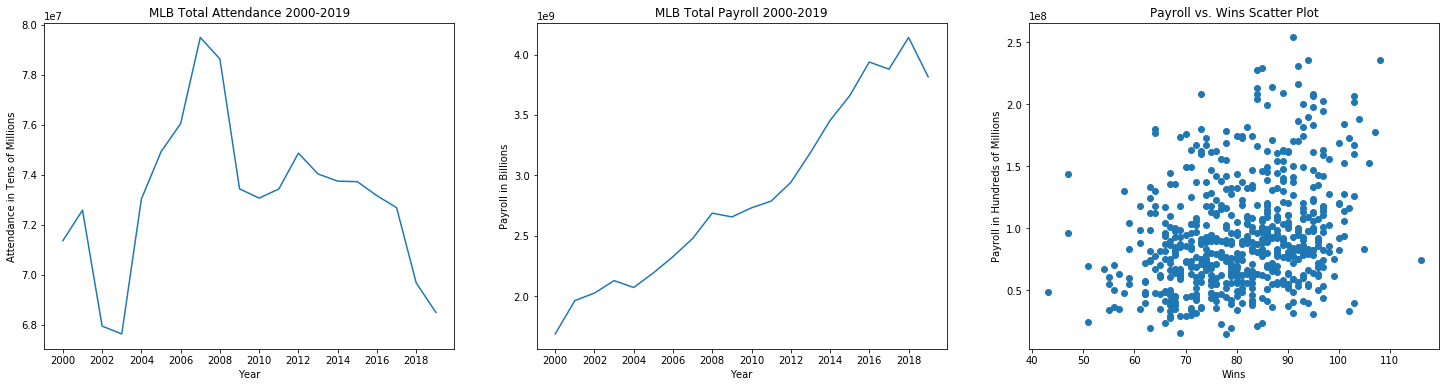

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,6))

axes[0].plot(attend)
axes[0].set_title('MLB Total Attendance 2000-2019')
axes[0].set_ylabel('Attendance in Tens of Millions')
axes[0].set_xlabel('Year')
axes[1].plot(payroll)
axes[1].set_title('MLB Total Payroll 2000-2019')
axes[1].set_ylabel('Payroll in Billions')
axes[1].set_xlabel('Year')
axes[2].scatter(x_wins, y_payroll)
axes[2].set_title('Payroll vs. Wins Scatter Plot')
axes[2].set_ylabel('Payroll in Hundreds of Millions')
axes[2].set_xlabel('Wins')

^ From the above, we see a few notable things:

* Attendance took a dive after the 2001 season, but then built up in a hurry all the way to 2007/2008, and then we see a massive fall off again. We believe the first drop to be a reflection of the end of the "steroids era", when the stars (Sammy Sosa, Mark McGwire, Barry Bonds) were at the end of their careers and home run totals leveled off. The fall off after 2008 almost certainly has a lot to do with the housing crisis that led to a major market crash. People simply did not have as much money to devote to entertainment.
* We see steady inclines in overall payroll, it more than doubled from the beginning of our sample to the end. This is probably due to economic factors as well, with economic growth bringing more revenue to the league. The Internet boom also brought in many more ways for teams to make money. We did see a drop off in Payroll from 2018 to 2019, which may be a sign of things to come - revenue can't increase forever, after all.
* The payroll vs. wins scatter plot show a bit of a relationship between the two variables, but it is far from being a straight line. Spending more money does raise your chances of success, but by no means does it guarantee it.

Text(0.5, 0, 'Year')

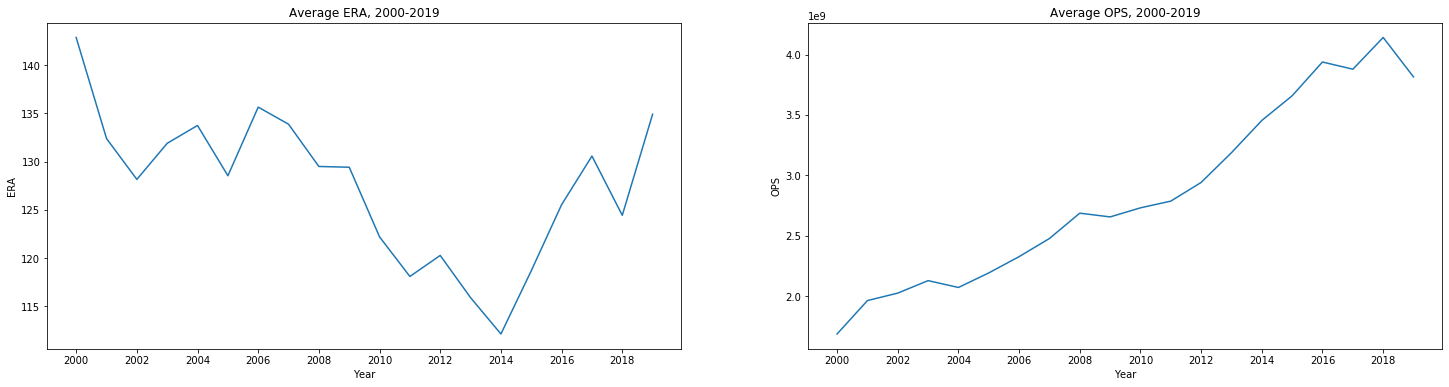

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,6))

axes[0].plot(avgera)
axes[0].set_title('Average ERA, 2000-2019')
axes[0].set_ylabel('ERA')
axes[0].set_xlabel('Year')
axes[1].plot(payroll)
axes[1].set_title('Average OPS, 2000-2019')
axes[1].set_ylabel('OPS')
axes[1].set_xlabel('Year')

* **Earned Run Average (ERA)**: Earned Runs Allowed Times 9 Divided by Innings Pitched. This number represents the average number of earned runs (runs that score that did not involve a fielding error) a team will allow over 9 innings (the length of a standard game). 
* **On Base Plug Slugging Percentage (OPS)**: A sum of on-base percentage and slugging percentage. On-base percentage is simply the percent of a team's plate appearances where their player reaches base. Slugging percentage is a measure of the batting productivity of a hitter. It is calculated as total bases divided by at bats. Unlike batting average, slugging percentage gives more weight to extra-base hits with doubles, triples, and home runs, relative to singles.

It is hard to quantify a team's performance in just two statistical categories, but we feel that these two stats best represent each side of the game. Recently, we have seen ERA's rising as hitters have really become more dominant over time. The league has broken the total home runs hit record in each of the last two years (2018 and 2019).

(5000000, 250000000)

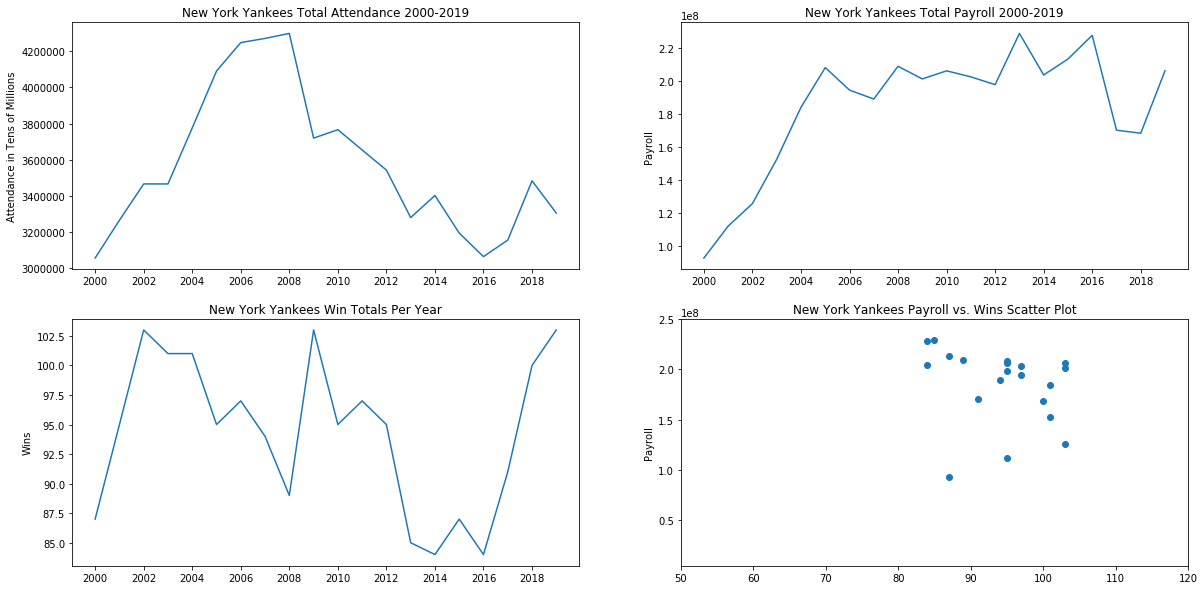

In [8]:
team='New York Yankees'

teamdf = mlb[mlb['Team']==team]
tm_wins = teamdf[['Year','W']]
tm_wins['Year'] = pd.to_datetime(tm_wins['Year'], format='%Y')
tm_wins = tm_wins.groupby(['Year'], as_index=True).sum()
tm_wins = tm_wins.sort_values(by='Year', ascending=True)
tm_attend = teamdf[['Year','Attend']]
tm_attend['Year'] = pd.to_datetime(tm_attend['Year'], format='%Y')
tm_attend = tm_attend.groupby(['Year'], as_index=True).sum()
tm_attend = tm_attend.sort_values(by='Year', ascending=True)
tm_payroll = teamdf[['Year','Payroll']]
tm_payroll['Year'] = pd.to_datetime(tm_payroll['Year'], format='%Y')
tm_payroll = tm_payroll.groupby(['Year'], as_index=True).sum()
tm_payroll = tm_payroll.sort_values(by='Year', ascending=True)
tm_x_wins = teamdf['W']
tm_y_payroll = teamdf['Payroll']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
axes[0,0].plot(tm_attend)
axes[0,0].set_title('%s Total Attendance 2000-2019' %team)
axes[0,0].set_ylabel('Attendance in Tens of Millions')
#axes[0,0].set_xlabel('Year')
axes[0,1].plot(tm_payroll)
axes[0,1].set_title('%s Total Payroll 2000-2019' %team)
axes[0,1].set_ylabel('Payroll')
#axes[0,1].set_xlabel('Year')
axes[1,0].plot(tm_wins)
axes[1,0].set_title('%s Win Totals Per Year' %team)
axes[1,0].set_ylabel('Wins')
#axes[1,0].set_xlabel('Year')
axes[1,1].scatter(tm_x_wins, tm_y_payroll)
axes[1,1].set_title('%s Payroll vs. Wins Scatter Plot' %team)
axes[1,1].set_ylabel('Payroll')
#axes[1,1].xlim(50,110)
plt.xlim(50,120)
plt.ylim(5000000, 250000000)
#axes[1,1].set_xlabel('Wins')

Here you can type in a team name and run the cell and it will show you these four graphs for the team. Comparing the New York Yankees to the Tampa Bay Rays really gives you a feel for how different attendance and payroll can be for teams playing in the same division.

In [0]:
# Correlations between ERA/W and OPS/W

wins = list(mlb['W'])
era = list(mlb['ERA'])
ops = list(mlb['OPS'])
pay = list(mlb['Payroll'])

era_corr = np.corrcoef(wins, era)
ops_corr = np.corrcoef(wins, ops)
pay_corr = np.corrcoef(wins, pay)

print('Correlation Coefficient with Win Total:')
print('ERA: ' + str(era_corr[0,1]))
print('OPS: ' + str(ops_corr[0,1]))
print('Payroll: ' + str(pay_corr[0,1]))

Correlation Coefficient with Win Total:
ERA: -0.6554937946792525
OPS: 0.5318056626770649
Payroll: 0.30319107249927596


We see the strongest correlation to winning with ERA, which makes sense since that number is directly about how many runs the team allows. OPS is not a strong as a relationship since it doesn't directly talk about runs scored - but it is very strongly correlated with runs scored, so we are kind of one step removed. Payroll's correlation with wins may surprise you, at a pretty low correlation at just 0.3.

Now we will build our model DataFrame and run the algorithms to get our predictions. In this project we use five different regression algorithms:

1. Linear
2. Decision Tree
3. Random Forest
4. Naive Bayes
5. K-Nearest Neighbor

Prepare the data specifically for modeling

In [9]:
modeldf = mlb[mlb['Year'] != '2019-01-01']
modeldf = modeldf.sample(frac=1)
modeldf['OPS'] = pd.to_numeric(modeldf['OPS'])
modeldf['ERA'] = pd.to_numeric(modeldf['ERA'])
modeldf['PayrollDiff'] = pd.to_numeric(modeldf['PayrollDiff'])
modeldf['AttendDiff'] = pd.to_numeric(modeldf['AttendDiff'])
modeldf['W'] = pd.to_numeric(modeldf['W'])
modeldf['NextYearW'] = pd.to_numeric(modeldf['NextYearW'])

stripped_df = modeldf[['W','OPS','ERA','PayrollDiff','AttendDiff','NextYearW']]
X = stripped_df.drop(['NextYearW'], axis=1)
y = stripped_df['NextYearW']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

print('X_train dimensions: ' + str(X_train.shape))
print('X_test dimensions: ' + str(X_test.shape))
print('y_train dimensions: ' + str(y_train.shape))
print('y_test dimensions: ' + str(y_test.shape))

X_train dimensions: (427, 5)
X_test dimensions: (143, 5)
y_train dimensions: (427,)
y_test dimensions: (143,)


In [0]:
linear_model = LinearRegression()
tree_model = DecisionTreeRegressor()
rf_model = RandomForestRegressor()
nb_model = BayesianRidge(compute_score=True)
knn_model = neighbors.KNeighborsRegressor(n_neighbors = 10)

linear_model.fit(X_train, y_train)
tree_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)

lm_preds = linear_model.predict(X_test)
tree_test_preds = tree_model.predict(X_test)
rf_test_preds = rf_model.predict(X_test)
nb_test_preds = nb_model.predict(X_test)
X_test_for_knn = X_test[['W','OPS','ERA','PayrollDiff','AttendDiff']]
knn_preds = knn_model.predict(X_test_for_knn)

X_test['LM_Pred'] = lm_preds
X_test['Tree_Pred'] = tree_test_preds
X_test['RF_Pred'] = rf_test_preds
X_test['NB_Pred'] = nb_test_preds
X_test['KNN_Pred'] = knn_preds
X_test['Actual'] = y_test

X_test['LM_Pred'] = round(X_test['LM_Pred'],0)
X_test['Tree_Pred'] = round(X_test['Tree_Pred'],0)
X_test['RF_Pred'] = round(X_test['RF_Pred'],0)
X_test['NB_Pred'] = round(X_test['NB_Pred'],0)
X_test['KNN_Pred'] = round(X_test['KNN_Pred'],0)

teams_years = mlb[['Team','Year']]
teams_years['ID'] = teams_years.index
X_test['ID'] = X_test.index
viewdf = pd.merge(X_test, teams_years, on='ID')
viewdf = viewdf[['ID','Team','Year','W','OPS','ERA','PayrollDiff','AttendDiff','LM_Pred','Tree_Pred','RF_Pred','NB_Pred', 'KNN_Pred','Actual']]

In [11]:
viewdf['LM_Error'] = abs(viewdf['Actual'] - viewdf['LM_Pred'])
viewdf['Tree_Error'] = abs(viewdf['Actual'] - viewdf['Tree_Pred'])
viewdf['RF_Error'] = abs(viewdf['Actual'] - viewdf['RF_Pred'])
viewdf['NB_Error'] = abs(viewdf['Actual'] - viewdf['NB_Pred'])
viewdf['KNN_Error'] = abs(viewdf['Actual'] - viewdf['KNN_Pred'])

viewdf.loc[viewdf['LM_Error'] <= 5, 'LM_Within5'] = 1
viewdf.loc[viewdf['Tree_Error'] <= 5, 'Tree_Within5'] = 1
viewdf.loc[viewdf['RF_Error'] <= 5, 'RF_Within5'] = 1
viewdf.loc[viewdf['NB_Error'] <= 5, 'NB_Within5'] = 1
viewdf.loc[viewdf['KNN_Error'] <= 5, 'KNN_Within5'] = 1

viewdf.loc[viewdf['LM_Error'] > 5, 'LM_Within5'] = 0
viewdf.loc[viewdf['Tree_Error'] > 5, 'Tree_Within5'] = 0
viewdf.loc[viewdf['RF_Error'] > 5, 'RF_Within5'] = 0
viewdf.loc[viewdf['NB_Error'] > 5, 'NB_Within5'] = 0
viewdf.loc[viewdf['KNN_Error'] > 5, 'KNN_Within5'] = 0

lm_avg_error = round(np.mean(viewdf['LM_Error']),0)
tree_avg_error = round(np.mean(viewdf['Tree_Error']),0)
rf_avg_error = round(np.mean(viewdf['RF_Error']),0)
nb_avg_error = round(np.mean(viewdf['NB_Error']),0)
knn_avg_error = round(np.mean(viewdf['KNN_Error']),0)

lm_within5 = round(sum(viewdf['LM_Within5']) / len(viewdf),2)
tree_within5 = round(sum(viewdf['Tree_Within5']) / len(viewdf),2)
rf_within5 = round(sum(viewdf['RF_Within5']) / len(viewdf),2)
nb_within5 = round(sum(viewdf['NB_Within5']) / len(viewdf),2)
knn_within5 = round(sum(viewdf['KNN_Within5']) / len(viewdf),2)

print('Linear Model Average Error: ' + str(lm_avg_error))
print('Decision Tree Average Error: ' + str(tree_avg_error))
print('Random Forest Average Error: ' + str(rf_avg_error))
print('Naive Bayes Average Error: ' + str(nb_avg_error))
print('K-Neighbors Average Error: ' + str(knn_avg_error))

print('\nLinear Model Within 5 Rate: ' + str(lm_within5))
print('Decision Tree Within 5 Rate: ' + str(tree_within5))
print('Random Forest Within 5 Rate: ' + str(rf_within5))
print('Naive Bayes Within 5 Rate: ' + str(nb_within5))
print('K-Neighbors Within 5 Rate: ' + str(knn_within5))

Linear Model Average Error: 8.0
Decision Tree Average Error: 12.0
Random Forest Average Error: 9.0
Naive Bayes Average Error: 8.0
K-Neighbors Average Error: 8.0

Linear Model Within 5 Rate: 0.44
Decision Tree Within 5 Rate: 0.24
Random Forest Within 5 Rate: 0.32
Naive Bayes Within 5 Rate: 0.38
K-Neighbors Within 5 Rate: 0.43


You get slightly different results every time you run this, but in general we see the Linear, Naive Bayes, and KNN working best. In terms of the percent of the time getting predictions accurate within 5 wins, Linear and KNN take the cake, consistently being above 40%.

In [12]:
# Predict next year
# We can do this more accurately by subbing in the payroll estimates for 2020 after the free agent signing period ends in January
mlb19 = mlb[mlb['Year'] == '2019-01-01']
mlb19_model = mlb19[['W','OPS','ERA','PayrollDiff','AttendDiff']]

lm_pred = linear_model.predict(mlb19_model)
tree_pred = tree_model.predict(mlb19_model)
rf_pred = rf_model.predict(mlb19_model)
nb_pred = nb_model.predict(mlb19_model)
knn_pred = knn_model.predict(mlb19_model)

mlb19_model['LM_Pred'] = lm_pred
mlb19_model['Tree_Pred'] = tree_pred
mlb19_model['RF_Pred'] = rf_pred
mlb19_model['NB_Pred'] = nb_pred
mlb19_model['KNN_Pred'] = knn_pred

mlb19_teams = mlb19[['Team']]
mlb19_teams['ID'] = mlb19_teams.index
mlb19_model['ID'] = mlb19_model.index

viewdf19 = pd.merge(mlb19_model, mlb19_teams, on='ID')
viewdf19 = viewdf19[['Team','LM_Pred','Tree_Pred','RF_Pred','NB_Pred','KNN_Pred']]
viewdf19['LM_Pred'] = round(viewdf19['LM_Pred'],0)
viewdf19['Tree_Pred'] = round(viewdf19['Tree_Pred'],0)
viewdf19['RF_Pred'] = round(viewdf19['RF_Pred'],0)
viewdf19['NB_Pred'] = round(viewdf19['NB_Pred'],0)
viewdf19['KNN_Pred'] = round(viewdf19['KNN_Pred'],0)

viewdf19 = viewdf19.sort_values(by='LM_Pred', ascending=False)
viewdf19


,Team,LM_Pred,Tree_Pred,RF_Pred,NB_Pred,KNN_Pred
10,Houston Astros,101.0,107.0,93.0,96.0,95.0
13,Los Angeles Dodgers,100.0,101.0,99.0,96.0,95.0
18,New York Yankees,95.0,107.0,95.0,94.0,97.0
16,Minnesota Twins,93.0,103.0,96.0,92.0,92.0
29,Washington Nationals,89.0,95.0,89.0,88.0,90.0
1,Atlanta Braves,89.0,83.0,82.0,90.0,87.0
4,Chicago Cubs,88.0,88.0,87.0,84.0,84.0
19,Oakland Athletics,88.0,81.0,84.0,89.0,86.0
26,Tampa Bay Rays,87.0,77.0,92.0,88.0,85.0
3,Boston Red Sox,87.0,69.0,85.0,84.0,84.0


Here are our predictions for next year using all five algorithms. Since we feel most confident in our linear and KNN algorithms, I have sorted by the Linear column. From the perspective of someone who pays attention to the game closely, these win totals really do make sense, and I think they will line up pretty well with what you see coming out of Vegas come spring time. 